<a href="https://colab.research.google.com/github/hoangp/isbi-datasets/blob/upload_colab/CNN_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install / Import dependencies

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

### Load datasets


In [0]:
# mounth gdrive
from google.colab import drive
drive.mount('/content/gdrive')

project_path = 'gdrive/My Drive/cs9517-19t2-project'

In [0]:
#!rm -rf gdrive/My\ Drive/cs9517-19t2-project/output

# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project
# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output
# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/aug
# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet
# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet/models
# !mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet/results

### Parameters

In [0]:
data_train_path = project_path + '/data/images'
data_label_path = project_path + '/data/labels_tiff'

output_path     = project_path + '/output'  
aug_path        = project_path + '/output/aug' 

image_size = 512
target_size = 512     # smaller target_size for quicker training

num_aug_batches = 38  # total augmented images = num_imgs * num_aug_batches

### Cross validation parameters

In [0]:
# get data images and labels filenames
data_train_filenames = glob.glob(data_train_path + "/*.jpg")
data_label_filenames = glob.glob(data_label_path + "/*.tif")
data_train_filenames.sort()
data_label_filenames.sort()

folds = []
for i in range(10):
    fold = {}
    test_index = [0+i, 10+i, 20+i]
    fold['test_index'] = test_index
    fold['train_filenames'] = [data_train_filenames[k] for k in range(len(data_train_filenames)) if not k in test_index]
    fold['label_filenames'] = [data_label_filenames[k] for k in range(len(data_label_filenames)) if not k in test_index]
    fold['test_filenames'] = [data_train_filenames[k] for k in range(len(data_train_filenames)) if k in test_index]
    fold['test_label_filenames'] = [data_label_filenames[k] for k in range(len(data_label_filenames)) if k in test_index]
    fold['result_names'] = ['result-' + fold['test_filenames'][k].split('/')[-1].split('.')[0] for k in range(len(fold['test_filenames']))]
    folds.append(fold)
    
print(folds[3]['result_names'])

['result-train-volume03', 'result-train-volume13', 'result-train-volume23']


### Load and pre-process original data

In [0]:
# fold number
fn = 0

# get data images and labels filenames
train_filenames = folds[fn]['train_filenames'] 
label_filenames = folds[fn]['label_filenames'] 
test_filenames = folds[fn]['test_filenames'] 
test_label_filenames = folds[fn]['test_label_filenames'] 

# TRAIN data
X_org = np.ndarray((len(train_filenames), target_size, target_size, 1), dtype=np.uint8)
y_org = np.ndarray((len(train_filenames), target_size, target_size, 1), dtype=np.uint8)
for i in range(len(train_filenames)):
    arr_t = img_to_array(load_img(train_filenames[i], color_mode = "grayscale"))
    arr_l = img_to_array(load_img(label_filenames[i], color_mode = "grayscale"))
    if i % 10 == 0:
        print('loading', train_filenames[i].split('/')[-1], 'and', 
                         label_filenames[i].split('/')[-1], '...')
    # resize for faster training
    if target_size < image_size:
        arr_t = resize(arr_t, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        arr_l = resize(arr_l, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)        
    X_org[i] = arr_t
    y_org[i] = arr_l

# TEST data
X_test = np.ndarray((len(test_filenames), target_size, target_size, 1), dtype=np.uint8)
y_test = np.ndarray((len(test_filenames), target_size, target_size, 1), dtype=np.uint8)
for i in range(len(test_filenames)):
    arr_t = img_to_array(load_img(test_filenames[i], color_mode = "grayscale"))
    arr_l = img_to_array(load_img(test_label_filenames[i], color_mode = "grayscale"))
    # resize for faster training
    if target_size < image_size:
        arr_t = resize(arr_t, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        arr_l = resize(arr_l, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)        
    X_test[i] = arr_t
    y_test[i] = arr_l
    
    
# CODE SNIPPETS: Split data into train and test set
# from sklearn.model_selection import train_test_split
# X_org, X_test, y_org, y_test = train_test_split(X_org, y_org, test_size=0.2)
# X_test /= 255.0
# y_test /= 255.0

# TRAIN ALL and TEST ALL DATA
# X_test = X_org
# y_test = y_org

# MANUAL SPLIT train/test (test_size=0.1)
# X_test = X_org[:3:,:,:,:]
# y_test = y_org[:3:,:,:,:]
# X_org  = X_org[3:,:,:,:]
# y_org  = y_org[3:,:,:,:]

print('X_org : shape =', X_org.shape, ', min =', np.min(X_org), ', max =', np.max(X_org))
print('y_org : shape =', y_org.shape, ', min =', np.min(y_org), ', max =', np.max(y_org))
print('X_test: shape =', X_test.shape, ', min =', np.min(X_test), ', max =', np.max(X_test))
print('y_test: shape =', y_test.shape, ', min =', np.min(y_test), ', max =', np.max(y_test))

loading train-volume01.jpg and train-labels01.tif ...
loading train-volume12.jpg and train-labels12.tif ...
loading train-volume23.jpg and train-labels23.tif ...
X_org : shape = (27, 512, 512, 1) , min = 0 , max = 255
y_org : shape = (27, 512, 512, 1) , min = 0 , max = 255
X_test: shape = (3, 512, 512, 1) , min = 0 , max = 255
y_test: shape = (3, 512, 512, 1) , min = 0 , max = 255


### Inspect original raw data

In [0]:
i = random.randint(0, target_size - 1)
print('X_org[0,'+str(i)+',:,:]')
print(np.transpose(X_org[0,i,:,:]), '\n')
print('y_org[0,'+str(i)+',:,:]',)
print(np.transpose(y_org[0,i,:,:]), '\n')
print('X_test[0,'+str(i)+',:,:]',)
print(np.transpose(X_test[0,i,:,:]), '\n')
print('y_test[0,'+str(i)+',:,:]',)
print(np.transpose(y_test[0,i,:,:]), '\n')

### Visualize a random original data

Original train / label image 0


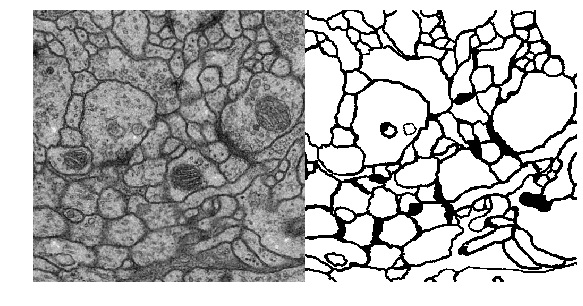

In [0]:
i = random.randint(0, len(X_org) - 1)

img_t = array_to_img(X_org[i])
img_l = array_to_img(y_org[i])

plt.figure(figsize=(10, 5))
plt.imshow(np.hstack((img_t, img_l)), cmap='gray')
plt.axis('off')
print('Original train / label image', i)

### Generate augmented images

In [0]:
# delete current augmentation data
!rm -rf gdrive/My\ Drive/cs9517-19t2-project/output/aug
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/aug

# Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
#
# ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
#     featurewise_std_normalization=False, samplewise_std_normalization=False, 
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, 
#     width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, 
#     shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', 
#     cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, 
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
#
# (https://keras.io/preprocessing/image/)

datagen = ImageDataGenerator(rotation_range=10, shear_range=0.1,  zoom_range=0.1,
     horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0)

num_imgs = len(X_org)

# merge label and train, one by one augmentation
for i in range(num_imgs):
    arr_t = X_org[i]
    arr_l = y_org[i]

    s = np.shape(arr_t) # either image_size or target_size
    
    # Create data & label arrays for ImageDataGenerator.flow()
    arr_tl = np.ndarray(shape=(s[0],s[1],3), dtype=np.uint8) # (size, size, 3)
    arr_tl[:,:,0] = arr_t[:,:,0]
    arr_tl[:,:,2] = arr_l[:,:,0]
    arr_tl = arr_tl.reshape((1,) + arr_tl.shape) # (1, size, size, 3) -> Rank 4

    if i % 10 == 0:
        print("Generate augmented data for data & label array " + str(i) + " ...")

    # Takes data & label arrays, generates batches of augmented data.
    # flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, 
    #      save_to_dir=None, save_prefix='', save_format='png', subset=None)
    batches = 0
    for batch in datagen.flow(arr_tl, batch_size=1, save_to_dir=aug_path, save_prefix=str(i)):
        batches += 1
        if batches >= num_aug_batches:
            break
            # we need to break the loop by hand because
            # the generator loops indefinitely       

aug_filenames = glob.glob(aug_path + "/*.*")
aug_filenames.sort()

print("No. of augmented images =", len(aug_filenames), "(saved to " + aug_path + ")")

Generate augmented data for data & label array 0 ...
Generate augmented data for data & label array 10 ...
Generate augmented data for data & label array 20 ...
No. of augmented images = 1022 (saved to gdrive/My Drive/cs9517-19t2-project/output/aug)


### Inspect data stored in an augmented image

In [0]:
arr = img_to_array(load_img(aug_filenames[0]))
X_t = arr[:,:,:1]
y_t = arr[:,:,2:]

i = random.randint(0, target_size - 1)
print('X_t['+str(i)+',:,:]')
print(np.transpose(X_t[i,:,:]), '\n')
print('y_t['+str(i)+',:,:]',)
print(np.transpose(y_t[i,:,:]), '\n')

### Visuazlize augmented images of a random data

No. of augmented images for data 5 = 38


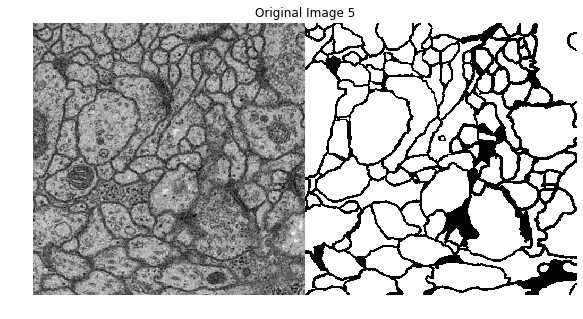

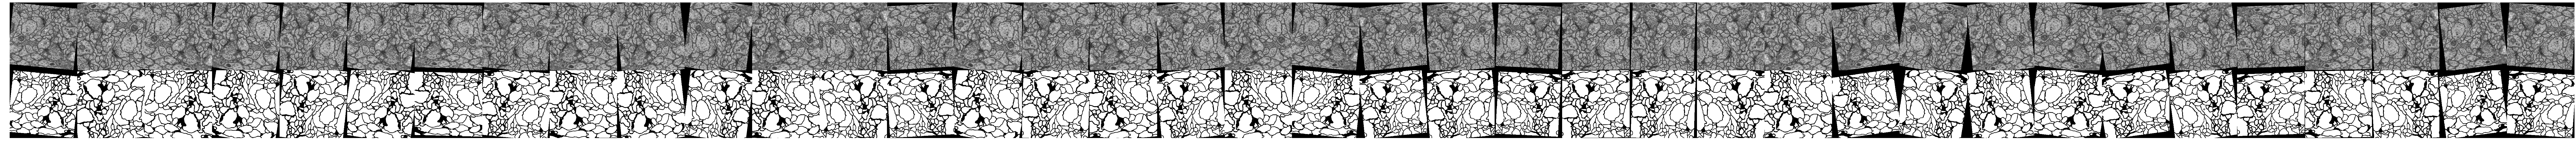

In [0]:
i = random.randint(0, len(X_org) - 1)

img_t = array_to_img(X_org[i])
img_l = array_to_img(y_org[i])

plt.figure(1, figsize=(10, 5))
plt.imshow(np.hstack((img_t, img_l)), cmap='gray')
plt.axis('off')
plt.title("Original Image " + str(i))

aug_select = [aug_filenames[j] for j in range(len(aug_filenames)) if int(aug_filenames[j].split('/')[-1].split('_')[0]) == i]
num_aug = len(aug_select)

list_a = []
for k in range(num_aug):
    arr = img_to_array(load_img(aug_select[k]))
    arr2 = np.concatenate((array_to_img(arr[:,:,:1]), array_to_img(arr[:,:,2:])), axis=0)
    list_a.append(arr2)

plt.figure(2, figsize=(5 * num_aug, 10))
plt.imshow(np.hstack(tuple(list_a)), cmap='gray')
plt.axis('off')
print("No. of augmented images for data " + str(i) + " = " + str(num_aug)) 

### Create train data from original data and augmented images

In [0]:
#aug_filenames = glob.glob(aug_path + "/*.*")
#aug_filenames.sort()

X_train = np.ndarray((len(X_org) + len(aug_filenames), target_size, target_size, 1), dtype=np.float32)
y_train = np.ndarray((len(X_org) + len(aug_filenames), target_size, target_size, 1), dtype=np.float32)

# Use X_org and y_org as train data
print("loading X_org/y_org as training data ...")
for i in range(len(X_org)):
    X_train[i] = X_org[i]
    y_train[i] = y_org[i]

# Load images from augmentation folder
for i in range(len(aug_filenames)):
    if i % 100 == 0:
        print("loading augmented image " + str(i) + " ...")
    arr = img_to_array(load_img(aug_filenames[i]))
    X_train[len(X_org) + i] = arr[:,:,:1]
    y_train[len(X_org) + i] = arr[:,:,2:]
    
# convert X_train / y_train to 0..1
X_train /= 255.0
y_train /= 255.0

# convert y_train to 0 or 1
y_train[y_train > 0.5] = 1
y_train[y_train <= 0.5] = 0

# OPTIONAL: save train data to disk
# print('Saving train dara to disk...')
# np.save(output_path + '/X_train.npy', X_train)
# np.save(output_path + '/y_train.npy', y_train)

print('X_train: shape =', X_train.shape, ', min =', np.min(X_train), ', max =', np.max(X_train))
print('y_train: shape =', y_train.shape, ', min =', np.min(y_train), ', max =', np.max(y_train))

loading X_org/y_org as training data ...
loading augmented image 0 ...
loading augmented image 100 ...
loading augmented image 200 ...
loading augmented image 300 ...
loading augmented image 400 ...
loading augmented image 500 ...
loading augmented image 600 ...
loading augmented image 700 ...
loading augmented image 800 ...
loading augmented image 900 ...
loading augmented image 1000 ...
X_train: shape = (1049, 512, 512, 1) , min = 0.0 , max = 1.0
y_train: shape = (1049, 512, 512, 1) , min = 0.0 , max = 1.0


### Inspect train data

In [0]:
X_t = X_train[0]
y_t = y_train[0]

i = random.randint(0, target_size - 1)
print('X_t['+str(i)+',:,:]')
print(np.transpose(X_t[i,:,:]), '\n')
print('y_t['+str(i)+',:,:]',)
print(np.transpose(y_t[i,:,:]), '\n')

### Visuazlize a random train data

X_train | y_train 265


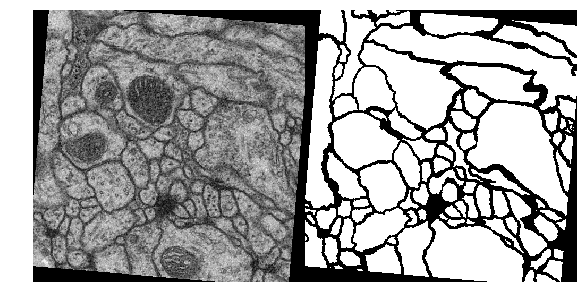

In [0]:
i = random.randint(0, len(X_train) - 1)

img_t = array_to_img(X_train[i])
img_l = array_to_img(y_train[i])

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack((img_t, img_l)), cmap='gray')
plt.axis('off')
print('X_train | y_train', i)

## CNN models

### UNet

In [0]:
from keras.layers import *

class UNet:
    def __init__(self, target_size = None):
        self.target_size = target_size
        self.model = None
        if target_size:
            self.model = self._get_unet()
        
        self.batch_size = None
        self.model_save_path = output_path + '/unet/models'
        self.result_save_path = output_path + '/unet/results'

    def _get_unet(self):
        from keras.models import Model
        from keras.optimizers import Adam
        inputs = Input((self.target_size, self.target_size,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6],axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7],axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 =concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        model = Model(inputs = inputs, outputs = conv10)
        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
        return model
    
    def disp_summary(self):
        seld.model.summary()
        
    def train(self, X_train, y_train, batch_size, epochs):
        # Trains the model for a given number of epochs (iterations on a dataset).
        # fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
        #     validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
        #     sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
        # batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32.
        # verbose: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        # (https://keras.io/models/model/) 
        
        save_name = "epochs:{epoch:02d}-loss:{loss:.3f}-val_acc:{val_acc:.3f}"
        
        save_name += '-unet' + '.shape-' + str(target_size) + \
                               '.train-' + str(len(X_train)) + \
                               '.batch-' + str(batch_size) + \
                               '.epoch-' + str(epochs)
        
        from keras.callbacks import ModelCheckpoint
        model_checkpoint = ModelCheckpoint(self.model_save_path + '/' + save_name + '.hdf5', 
                                           monitor='loss', verbose=1, save_best_only=True)       
        self.model.fit(X_train, y_train, batch_size, epochs, 
                       validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
    def predict(self, X_test):
        if np.max(X_test) > 1:
            print("Convert test data to float32 range 0..1")
            X_test = X_test.astype(np.float32) / 255.0
        return self.model.predict(X_test, batch_size=self.batch_size, verbose=1)
    
    def predict_and_save(self, X_test, save_names = None, save_format = 'jpg'):
        y_pred = self.predict(X_test)   
        print('Saving ' + str(len(y_pred)) + ' images to ' + self.result_save_path)       
        for i in range(len(y_pred)):
            save_name = save_names[i] if save_names else str(i)
            io.imsave(self.result_save_path + "/" + save_name + "." + save_format, y_pred[i])       
        return y_pred
        
    def load(self, filepath):         
        # extract model info from filename
        s_path   = filepath.split('/')
        s_name   = s_path[-1].split('.')  # ['unet', 'shape-128', 'train-700', 'batch-4', 'epoch-5', 'hdf5']
        s_target = s_name[1].split('-')   # ['shape', '128']
        s_batch  = s_name[3].split('-')   # ['batch', '4']
        self.target_size = int(s_target[1])
        self.batch_size  = int(s_batch[1])
        
        print('loading model ' +  s_path[-1] + ' ...')     
        
        from keras.models import load_model
        self.model = load_model(filepath)   

### Select a model

In [0]:
model = UNet(target_size)

### Train

In [0]:
model.train(X_train, y_train, batch_size=4, epochs=1)

Train on 839 samples, validate on 210 samples
Epoch 1/1
839/839 [==============================] - 272s 324ms/step - loss: 0.6413 - acc: 0.7347 - val_loss: 0.5391 - val_acc: 0.7123

Epoch 00001: loss improved from inf to 0.64126, saving model to gdrive/My Drive/cs9517-19t2-project/output/unet/models/epochs:01-loss:0.641-val_acc:0.712-unet.shape-512.train-1049.batch-4.epoch-1.hdf5


### Predict and save results to disk

In [0]:
y_pred = model.predict_and_save(X_test, save_names = folds[fn]['result_names'], save_format = 'jpg')

Convert test data to float32 range 0..1
3/3 [==============================] - 1s 253ms/step


W0730 06:08:31.425749 140251463001984 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0730 06:08:31.440403 140251463001984 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0730 06:08:31.452165 140251463001984 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Saving 3 images to gdrive/My Drive/cs9517-19t2-project/output/unet/results


### Inspect prediction data

In [0]:
i = random.randint(0, target_size - 1)
print('X_test[0,'+str(i)+',:,:]',)
print(np.transpose(X_test[0,i,:,:]))
print('y_pred[0,'+str(i)+',:,:]',)
print(np.transpose(y_pred[0,i,:,:]).astype(np.int16))
print('y_test[0,'+str(i)+',:,:]',)
print(np.transpose(y_test[0,i,:,:]))

### Visualize a random prediction

Comparision: original / prediction / ground-truth 0


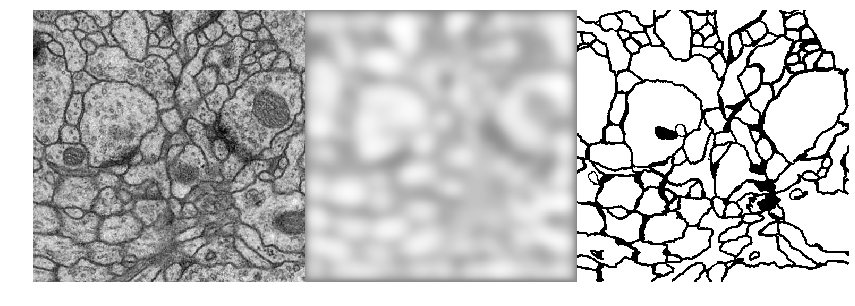

In [0]:
i = random.randint(0, len(X_test) - 1)

img_t = array_to_img(X_test[i])
img_p = array_to_img(y_pred[i])
img_l = array_to_img(y_test[i])

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack((img_t, img_p, img_l)), cmap='gray')
plt.axis('off')
print('Comparision: original / prediction / ground-truth', i)

### Show all predictions

In [0]:
for i in range(len(X_test)):
    img_t = array_to_img(X_test[i])
    img_p = array_to_img(y_pred[i])
    img_l = array_to_img(y_test[i])

    plt.figure(i, figsize=(15, 5))
    plt.imshow(np.hstack((img_t, img_p, img_l)), cmap='gray')
    plt.axis('off')

## Code Snippets

### Load model from file

In [0]:
model = UNet()
model.load(output_path + '/unet/models/final/unet.shape-512.train-765.batch-4.epoch-10.hdf5')

W0729 23:48:45.286109 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 23:48:45.339680 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 23:48:45.377089 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 23:48:45.444959 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 23:48:45.446019 139921540196224 depre

loading model unet.shape-512.train-765.batch-4.epoch-10.hdf5 ...


W0729 23:48:45.510875 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0729 23:48:45.676285 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 23:48:52.607599 139921540196224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 23:48:52.616548 139921540196224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future ver